In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

In [2]:
df = pd.read_csv('../AirbnbData/CleanData/df_modelo_limpio.csv')
df = df.drop(columns = (['Unnamed: 0', 'id', 'neighbourhood_group_cleansed', 'property_type']))
df

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,room_type,bedrooms,beds,price,availability_365,number_of_reviews,calculated_host_listings_count,reviews_per_month,bathrooms,puntuacion_media
0,1,1,Hispanoamérica,Private room,1.0,1.0,60.0,180,78,1,0.58,1.0,4.583333
1,0,1,Cármenes,Private room,1.0,1.0,31.0,364,33,2,0.42,1.0,4.653846
2,0,1,Legazpi,Private room,1.0,1.0,26.0,365,149,1,1.12,1.0,4.612613
3,0,0,Sol,Entire home/apt,1.0,2.0,65.0,351,170,3,1.29,1.0,4.596774
4,0,0,Embajadores,Entire home/apt,1.0,1.0,54.0,0,8,1,0.11,1.0,4.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11535,0,1,Castillejos,Entire home/apt,3.0,4.0,62.0,360,1,38,1.00,1.5,5.000000
11536,0,0,Sol,Private room,1.0,2.0,60.0,158,2,6,2.00,1.0,4.500000
11537,0,0,Almenara,Private room,1.0,1.0,25.0,175,1,1,1.00,1.0,5.000000
11538,0,1,Justicia,Entire home/apt,1.0,1.0,44.0,331,1,2,1.00,1.0,5.000000


In [3]:
df['bathrooms'] = df['bathrooms'].apply(lambda x: float(x))
df = df.dropna()

In [4]:
df.dtypes

host_is_superhost                   int64
host_identity_verified              int64
neighbourhood_cleansed             object
room_type                          object
bedrooms                          float64
beds                              float64
price                             float64
availability_365                    int64
number_of_reviews                   int64
calculated_host_listings_count      int64
reviews_per_month                 float64
bathrooms                         float64
puntuacion_media                  float64
dtype: object

### Datos

In [5]:
X = df.drop(columns = (['price']))

In [6]:
labelencoder = LabelEncoder()

X['host_is_superhost'] = labelencoder.fit_transform(X['host_is_superhost'])
X['host_identity_verified'] = labelencoder.fit_transform(X['host_identity_verified'])
X['neighbourhood_cleansed'] = labelencoder.fit_transform(X['neighbourhood_cleansed'])
X['room_type'] = labelencoder.fit_transform(X['room_type'])

In [7]:
CONTINUAL_COLUMNS = ['bedrooms', 'beds', 'number_of_reviews', 'bathrooms', 'puntuacion_media']

In [8]:
df[CONTINUAL_COLUMNS]=(df[CONTINUAL_COLUMNS]-df[CONTINUAL_COLUMNS].mean())/df[CONTINUAL_COLUMNS].std()


C:\Users\jaime\anaconda3\envs\swa-dev\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


(array([3794., 3503., 2135., 1050.,  527.,  312.,  202.]),
 array([  9.        ,  39.14285714,  69.28571429,  99.42857143,
        129.57142857, 159.71428571, 189.85714286, 220.        ]),
 <BarContainer object of 7 artists>)

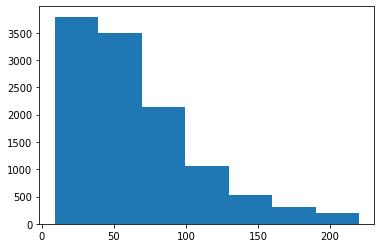

In [9]:
plt.hist(df['price'], bins = 7)

In [10]:
def assign_class(price):
    classif = 13 #si algun caso devuelve un 13 -> error
    if (price <= 35):
        classif = 0
    elif (35 < price <= 60):
        classif = 1
    elif (60 < price <= 90):
        classif = 2
    elif (90 < price <= 140):
        classif = 3
    elif (140 < price <= 300):
        classif = 4
        
    return classif

In [11]:
df['price'] = df['price'].apply(lambda x: assign_class(x))

C:\Users\jaime\AppData\Local\Temp\ipykernel_1732\2772249497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = df['price'].apply(lambda x: assign_class(x))


In [12]:
df['price'].value_counts()

0    3338
1    3216
2    2447
3    1706
4     816
Name: price, dtype: int64

In [13]:
y = df['price']

### Modelo

In [14]:
input_num = tf.keras.layers.Input(shape = (5,), name = "num_input")
input_cat1 = tf.keras.layers.Input(shape = (1,), name = "superhost")
input_cat2 = tf.keras.layers.Input(shape = (1,), name = "identity")
input_cat3 = tf.keras.layers.Input(shape = (1,), name = "neighbourhood")
input_cat4 = tf.keras.layers.Input(shape = (1,), name = "room")

x_numeric = tf.keras.layers.Dense(128, name = "encoding_num")(input_num)
x_categoric1 = tf.keras.layers.Embedding(input_dim = 2, output_dim = 3, name = "embedding_cat1")(input_cat1)
x_categoric1 = tf.keras.layers.Reshape(target_shape = (3,), name = "flat_vec1")(x_categoric1)
x_categoric2 = tf.keras.layers.Embedding(input_dim = 2, output_dim = 3, name = "embedding_cat2")(input_cat2)
x_categoric2 = tf.keras.layers.Reshape(target_shape = (3,), name = "flat_vec2")(x_categoric2)
x_categoric3 = tf.keras.layers.Embedding(input_dim = 126, output_dim = 3, name = "embedding_cat3")(input_cat3)
x_categoric3 = tf.keras.layers.Reshape(target_shape = (3,), name = "flat_vec3")(x_categoric3)
x_categoric4 = tf.keras.layers.Embedding(input_dim = 4, output_dim = 3, name = "embedding_cat4")(input_cat4)
x_categoric4 = tf.keras.layers.Reshape(target_shape = (3,), name = "flat_vec4")(x_categoric4)

x_all = tf.keras.layers.Concatenate()([x_numeric, x_categoric1,x_categoric2,x_categoric3,x_categoric4])
x_all = tf.keras.layers.Dense(512, name = "hidden_layer_1", activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x_all)
x_all = tf.keras.layers.Dropout(rate=0.2)(x_all)
x_all = tf.keras.layers.Dense(256, name = "hidden_layer_3", activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x_all)
x_all = tf.keras.layers.Dropout(rate=0.2)(x_all)
x_all = tf.keras.layers.Dense(256, name = "hidden_layer_4", activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x_all)
x_all = tf.keras.layers.Dropout(rate=0.2)(x_all)
x_all = tf.keras.layers.Dense(128, name = "hidden_layer_5", activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x_all)
x_all = tf.keras.layers.Dropout(rate=0.2)(x_all)
x_all = tf.keras.layers.Dense(64, name = "hidden_layer_6", activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x_all)
x_all = tf.keras.layers.Dropout(rate=0.2)(x_all)
x_all = tf.keras.layers.Dense(64, name = "hidden_layer_7", activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x_all)
x_all = tf.keras.layers.Dropout(rate=0.2)(x_all)
x_all = tf.keras.layers.Dense(32, name = "hidden_layer_8", activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x_all)
x_all = tf.keras.layers.Dropout(rate=0.2)(x_all)
x_all = tf.keras.layers.Dense(5, name = "final_layer", activation = "softmax")(x_all)
model_in = tf.keras.models.Model([input_num, input_cat1, input_cat2, input_cat3, input_cat4], x_all, name = "funct_model_all")

In [15]:
print(model_in.summary())

Model: "funct_model_all"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 superhost (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 identity (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 neighbourhood (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 room (InputLayer)              [(None, 1)]          0           []                               
                                                                                    

In [16]:
model_in.compile("adam", "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [17]:
history = model_in.fit((X[CONTINUAL_COLUMNS], X['host_is_superhost'], X['host_identity_verified'], X['neighbourhood_cleansed'], X['room_type']), 
                              y, batch_size = 64, epochs = 100, validation_split = 0.2)

Epoch 1/100
145/145 [==============================] - 8s 28ms/step - loss: 1.8254 - accuracy: 0.2683 - val_loss: 1.6716 - val_accuracy: 0.3124
Epoch 2/100
145/145 [==============================] - 3s 22ms/step - loss: 1.6832 - accuracy: 0.2940 - val_loss: 1.5321 - val_accuracy: 0.4395
Epoch 3/100
145/145 [==============================] - 3s 23ms/step - loss: 1.5927 - accuracy: 0.3693 - val_loss: 1.4623 - val_accuracy: 0.4416
Epoch 4/100
145/145 [==============================] - 4s 26ms/step - loss: 1.5243 - accuracy: 0.4054 - val_loss: 1.4294 - val_accuracy: 0.4421
Epoch 5/100
145/145 [==============================] - 3s 23ms/step - loss: 1.4712 - accuracy: 0.4344 - val_loss: 1.4241 - val_accuracy: 0.4425
Epoch 6/100
145/145 [==============================] - 3s 23ms/step - loss: 1.4164 - accuracy: 0.4505 - val_loss: 1.3606 - val_accuracy: 0.4698
Epoch 7/100
145/145 [==============================] - 3s 23ms/step - loss: 1.3713 - accuracy: 0.4719 - val_loss: 1.3416 - val_accuracy:

145/145 [==============================] - 3s 17ms/step - loss: 1.1221 - accuracy: 0.5269 - val_loss: 1.2251 - val_accuracy: 0.4751
Epoch 58/100
145/145 [==============================] - 3s 17ms/step - loss: 1.1163 - accuracy: 0.5261 - val_loss: 1.1738 - val_accuracy: 0.5033
Epoch 59/100
145/145 [==============================] - 3s 17ms/step - loss: 1.1116 - accuracy: 0.5274 - val_loss: 1.1975 - val_accuracy: 0.4946
Epoch 60/100
145/145 [==============================] - 3s 17ms/step - loss: 1.1210 - accuracy: 0.5261 - val_loss: 1.1781 - val_accuracy: 0.5007
Epoch 61/100
145/145 [==============================] - 3s 17ms/step - loss: 1.1153 - accuracy: 0.5294 - val_loss: 1.1680 - val_accuracy: 0.5028
Epoch 62/100
145/145 [==============================] - 3s 17ms/step - loss: 1.1184 - accuracy: 0.5258 - val_loss: 1.1998 - val_accuracy: 0.5002
Epoch 63/100
145/145 [==============================] - 3s 17ms/step - loss: 1.1087 - accuracy: 0.5289 - val_loss: 1.1852 - val_accuracy: 0.505

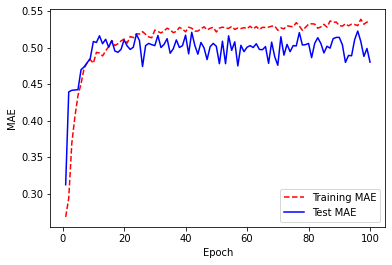

In [18]:
training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_acc) + 1)

plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training MAE', 'Test MAE'])
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show();